## Visualization

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue);  library(glue); library(lubridate)
    library(scales); library(RColorBrewer); library(dplyr); library(tidyr); library(ggplot2)
    library(ggthemes); library(polloi)
})

In [2]:
file <- "metrics/metrics.tsv"
pageview <- read.csv(file, sep = '\t')
pageview$month <- as.Date(pageview$month, format = "%Y-%m-%d")

In [3]:
head(pageview)

,month,automated_pageviews,desktop,gs_interactions,gs_pageviews,gs_previews,interactions,mh_interactions,mh_pageviews,mh_previews,mobileweb,previews_seen,total_pageview,unique_devices
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-07-01,NA,7319709535,NA,NA,NA,NA,NA,NA,NA,6951477838,NA,14479097793,NA
2,2016-08-01,NA,7808198322,NA,NA,NA,NA,NA,NA,NA,7158465508,NA,15164063733,NA
3,2016-09-01,NA,8015803318,NA,3509314705,NA,NA,NA,482166702,NA,7037821889,NA,15227361307,NA
4,2016-10-01,NA,8597813074,NA,3649168724,NA,NA,NA,584002147,NA,7454268064,NA,16205992870,NA
5,2016-11-01,NA,8756368629,NA,3682761207,NA,NA,NA,639332261,NA,7568847051,NA,16499874726,NA
6,2016-12-01,NA,8140608026,NA,3397813382,NA,NA,NA,566587960,NA,7623805561,NA,15964600507,NA


In [4]:
tail(pageview)

,month,automated_pageviews,desktop,gs_interactions,gs_pageviews,gs_previews,interactions,mh_interactions,mh_pageviews,mh_previews,mobileweb,previews_seen,total_pageview,unique_devices
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,2021-09-01,911629620,6293941138,4342241993,3949492178,392749815,17823784700,821283216,788543740,32739476,9454794487,1812546943,16011237757,1690496559
64,2021-10-01,901158808,6513036102,4356291999,3973495245,382796754,18360031885,NA,NA,NA,9701242496,1872863674,16487168211,1837564335
65,2021-11-01,881050513,6420327046,4247671454,3868069777,379601677,17768512101,NA,NA,NA,9209694162,1880481379,15888030722,1730051225
66,2021-12-01,955616294,5997304911,4053081990,3699153841,353928149,17629126726,NA,NA,NA,9545437010,1802475579,15826651147,1728498807
67,2022-01-01,1003626771,6657032289,4237581175,3860723508,376857667,19401297429,NA,NA,NA,10371244452,2058829668,17342467761,1775062017
68,2022-02-01,979406965,6381498663,4110316297,3767028146,343288151,17874089603,NA,NA,NA,9383265529,1833566161,16040523442,1827453153


### Pageviews Interactions 

In [5]:
pageview_fy <- pageview %>% 
     select(month,total_pageview,previews_seen) %>%
     mutate(previews_seen = replace_na(previews_seen, 0)) %>%
     mutate(interactions = total_pageview+previews_seen) %>%
     filter(month >= '2019-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2019-07-01' & month < '2020-07-01', 'FY 2019/20', ifelse(month <'2019-07-01','FY 2018/19',ifelse(month <'2021-07-01','FY 2020/21','FY 2021/22'))),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

pageview_fy$MonthN = factor(pageview_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))

In [6]:
tail(pageview_fy)

,month,total_pageview,previews_seen,interactions,fiscal_year,MonthN,Month
,<date>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>
27,2021-09-01,16011237757,1812546943,17823784700,FY 2021/22,09,Sep
28,2021-10-01,16487168211,1872863674,18360031885,FY 2021/22,10,Oct
29,2021-11-01,15888030722,1880481379,17768512101,FY 2021/22,11,Nov
30,2021-12-01,15826651147,1802475579,17629126726,FY 2021/22,12,Dec
31,2022-01-01,17342467761,2058829668,19401297429,FY 2021/22,01,Jan
32,2022-02-01,16040523442,1833566161,17874089603,FY 2021/22,02,Feb


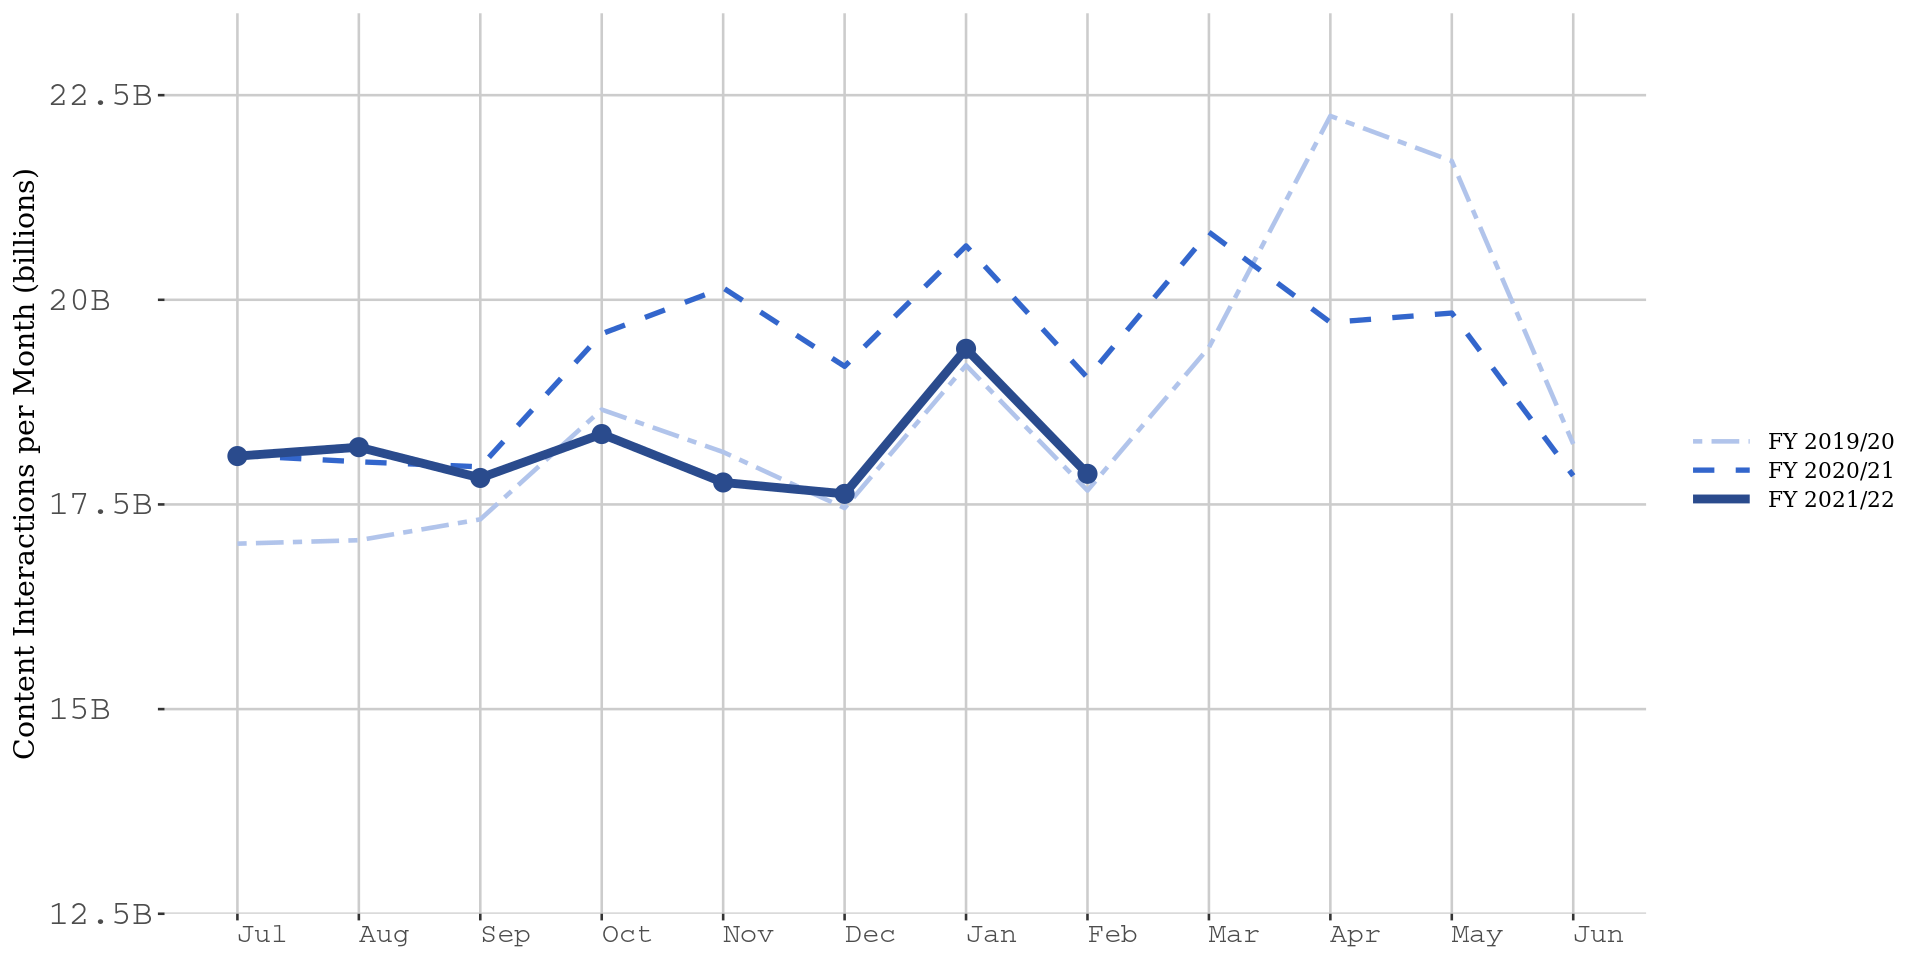

In [7]:
options(repr.plot.width = 16, repr.plot.height = 8)

p<- pageview_fy %>%
    ggplot(aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = interactions, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    geom_point(data=pageview_fy[(pageview_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=interactions, group=fiscal_year, color = fiscal_year),size = 5,color ="#2a4b8d")+

    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_size_manual(values = c(1.3,1.5,2.5)) +
    scale_color_manual(values = c("FY 2019/20"= "#b1c4eb", "FY 2020/21" = "#3366cc","FY 2021/22" = "#2a4b8d")) +
   # geom_vline(xintercept = 10, linetype = "dashed", color = "gray20") +
   # geom_text(aes(x=10, y=16.8E9, label="Page previews deployment (April 2018)"), size=5, vjust = -1, angle = 90, color = "gray20") +
   # geom_text(aes(x=10, y=16.8E9, label="China block all Wikipedias (April 2019)"), size=5, vjust = 1.5, angle = 90, color = "#b32424") +
    scale_x_discrete("Month",
                      breaks = pageview_fy$MonthN, 
                     labels = pageview_fy$Month) +
    scale_y_continuous("Content Interactions per Month (billions)",
                       labels = polloi::compress,
                       limits = c(13E9, 23E9)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.title.x=element_blank(),
         axis.text.x=element_text( hjust = 0,size = 17,family="Courier"),
           axis.text.y=element_text( hjust = 0,size = 21,family="Courier"),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=17,hjust = 0.5,vjust = -12),
          legend.position = "right", 
          panel.grid.minor.y = element_blank(),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 13),
          legend.key.width=unit(1.5,"cm"))
  p

In [ ]:
# Removed Interactions Bar - line chart as it is not used anymore